In [1]:
%matplotlib inline

In [2]:
import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [6]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    return inputs_real, inputs_z

In [7]:
def generator(z, out_dim, n_units=128, reuse=False, alpha=0.01):
    """
    Build the generator network.
    
    z: Input tensor for the generator
    out_dim: Shape of the generator output.
    n_units: Number of units in hidden layer
    reuse: Reuse the variables with tf.variable_scope
    alpha: leak parameter fot leaky Relu
    
    Returns:
    out:logits
    """
    
    with tf.variable_scope('generator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(z, n_units, activation=None)
        #Leaky ReLU
        h1 = tf.maximum(h1*alpha, h1)
        # Logits and tanh output
        logits = tf.layers.dense(h1, out_dim, activation=None)
        out = tf.tanh(logits)
        
        return out

In [8]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    """
    Build the discriminator network.
    
    x: Input tensor for the discriminator.
    n_units: Number of units in hidden layer
    reuse: Reuse the variables with tf.variable_scope
    alpha: leak parameter for leaky ReLU
    
    Return : out, logits
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(x, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(h1*alpha, h1)
        
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
        return out, logits
    
    

In [9]:
## Hyperparameters
input_size = 784 # 28*28 MNIST images flattened
# Size of latent vector to generator
z_size = 100
# Size of hidden layers in generator and discriminator
g_hidden_size = 128
d_hidden_size = 128
# Leak factor for leaky ReLU
alpha = 0.01
# Label smoothing
smooth = 0.1


In [12]:
## 建立网络
tf.reset_default_graph()
# Create our input placeholders
input_real, input_z = model_inputs(input_size, z_size)

# Generator network here
g_model = generator(input_z, input_size, n_units=g_hidden_size, alpha=alpha)

# Discriminator network here
d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=d_hidden_size, alpha=alpha)

In [15]:
## 鉴别器和发生器的损失

d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_logits_real) * (1 - smooth)))

d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_logits_real)))

d_loss = d_loss_real+d_loss_fake

g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_logits_fake)))

In [16]:
# Optimizers
learning_rate = 0.002

# Get the trainable_variables, split into G and D parts 
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
print(g_vars)
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

[<tf.Variable 'generator/dense/kernel:0' shape=(100, 128) dtype=float32_ref>, <tf.Variable 'generator/dense/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'generator/dense_1/kernel:0' shape=(128, 784) dtype=float32_ref>, <tf.Variable 'generator/dense_1/bias:0' shape=(784,) dtype=float32_ref>]


In [18]:
## Training
batch_size = 100
epochs = 100
samples = []
losses = []
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images * 2 - 1
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1,1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real : batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
            
        
        # At the end of each epoch ,get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
        
        print("Epoch {}/{}...".format(e+1, epochs),
             "Discriminator Loss: {:.4f}...".format(train_loss_d),
             "Generator Loss: {:.4f}".format(train_loss_g))
        
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(generator(input_z, input_size, n_units=g_hidden_size, 
                                        reuse=True, alpha=alpha), feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

        
# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)







Epoch 1/100... Discriminator Loss: 0.3538... Generator Loss: 4.2842
Epoch 2/100... Discriminator Loss: 0.3915... Generator Loss: 3.1661
Epoch 3/100... Discriminator Loss: 0.5366... Generator Loss: 2.2796
Epoch 4/100... Discriminator Loss: 0.9539... Generator Loss: 7.1681
Epoch 5/100... Discriminator Loss: 1.2209... Generator Loss: 4.2051
Epoch 6/100... Discriminator Loss: 0.9112... Generator Loss: 1.9225
Epoch 7/100... Discriminator Loss: 2.3922... Generator Loss: 0.9699
Epoch 8/100... Discriminator Loss: 1.6450... Generator Loss: 1.0313
Epoch 9/100... Discriminator Loss: 1.0413... Generator Loss: 2.4768
Epoch 10/100... Discriminator Loss: 0.9060... Generator Loss: 1.5204
Epoch 11/100... Discriminator Loss: 1.9105... Generator Loss: 0.7818
Epoch 12/100... Discriminator Loss: 0.9820... Generator Loss: 2.7550
Epoch 13/100... Discriminator Loss: 1.1627... Generator Loss: 2.1992
Epoch 14/100... Discriminator Loss: 1.1806... Generator Loss: 1.6320
Epoch 15/100... Discriminator Loss: 1.2856.

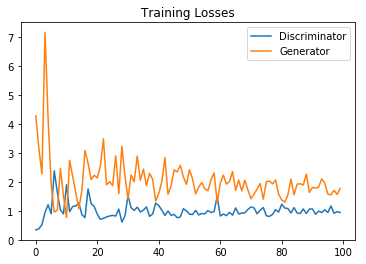

In [19]:
# 训练损失
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [25]:
# Generator samples from training
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

In [26]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

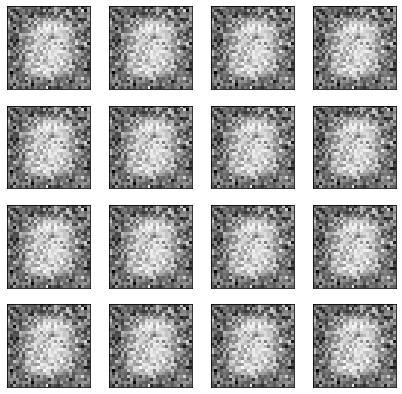

In [27]:
_ = view_samples(0, samples)

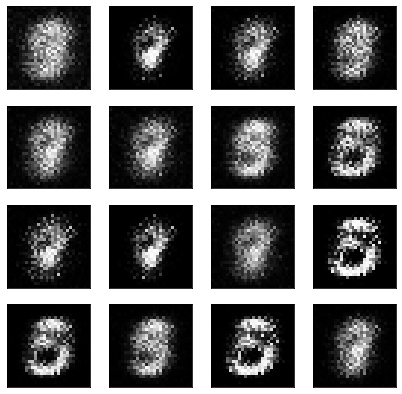

In [28]:
_ = view_samples(10, samples)

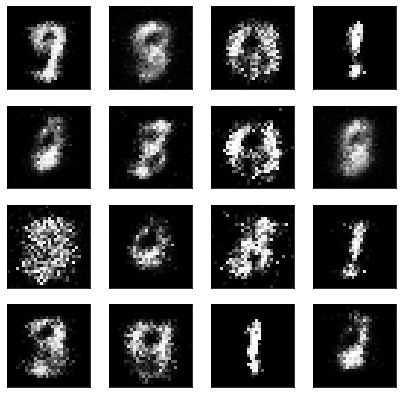

In [29]:
_ = view_samples(30, samples)

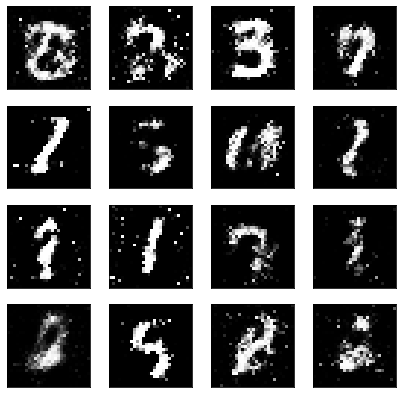

In [30]:
_ = view_samples(50, samples)

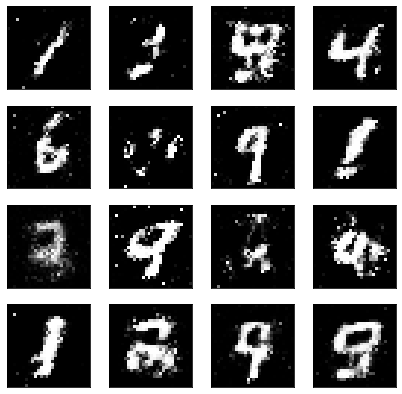

In [31]:
_ = view_samples(80, samples)

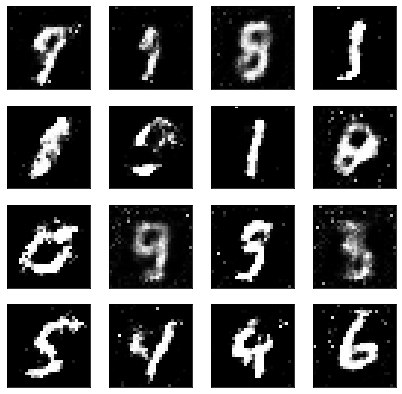

In [32]:
_ = view_samples(-1, samples)

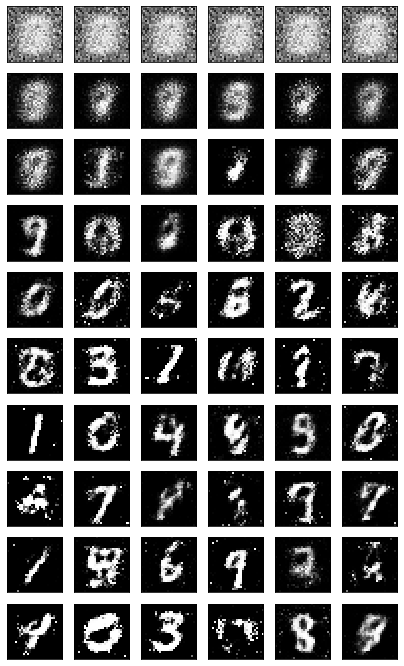

In [34]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


(<Figure size 504x504 with 16 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0xb45540cf8>,
       dtype=object))

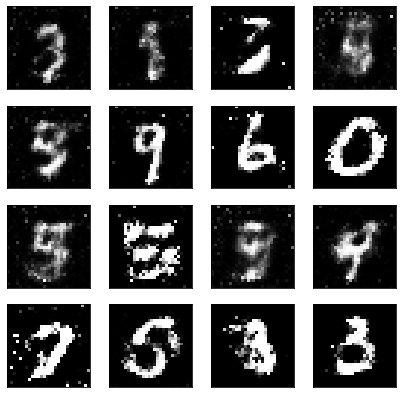

In [35]:
# generator采样
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1,1,size=(16, z_size))
    gen_samples = sess.run(
        generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
        feed_dict={input_z: sample_z}
    )
view_samples(0, [gen_samples])